Final Task : 2D HCl by Lawrence Arscott

This task is an MD Simulation of two-dimensional Hydrochloric acid.

Particles are initiated in a 2D box.

Three forces will be at play :
Bond forces will pair Hydrogen and Chlorine atoms together. They modelled according to a harmonic oscillator :

$$\vec{F_{bond, a, b}} = -k\left(|\vec{x_{a}} - \vec{x_{b}}| - r_{0}\right)\dfrac{\vec{x_{a}} - \vec{x_{b}}}{|\vec{x_{a}} - \vec{x_{b}}|}$$

All particles except particles within the same molecule interact via Coulomb forces:

$$\vec{F}_{Coul}(\vec{r}_{i, j})=\dfrac{1}{4\pi\varepsilon_{0}}\dfrac{q_{i}q_{j}}{r^{2}_{i, j}}\dfrac{\vec{r_{i, j}}}{r_{i, j}}$$

Finally, Chlorine atoms interact via van der Waals forces:

$$\vec{F_{LJ}}=\left(12\dfrac{C_{12}}{r_{i, j}^{13}} - 6\dfrac{C_{6}}{r_{i, j}^{13}}\right)\dfrac{\vec{r_{i, j}}}{r_{i, j}}$$

Particles will be moved according to the leap frog algorithm.
The Berendsen thermostat is used to simulate coupling to a heat bath.

Particles are initialised at a temperature of 10 000K, while a heat bath cools them down to 100K.

The goal is to observe crystalisation of the HCl molecules.

Import functions

In [765]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
import numpy.matlib as mb
from tqdm import tqdm
import random
import copy

In [651]:
class Boltzmann:
    '''Plot Boltzmann distribution and ascertain points from the graphs
    
    
    2D Boltzmann speed distribution
    Upon creation of a Boltzmann instance with particular values for temperature and mass, 
    values P(V = v) are calculated for a range values v. The parameter Boltz_Points gives
    the total number of points calculated. Using this data, data for a CDF curve is calculated.
    These curves can be plotted using the relevant functions, however the main use of this class
    is to assign speeds to particles according to the 2D Boltzmann distribution.
        
    Parameters
    ----------
    Boltz_Points : int
        The number of x values to be used to create the data
    T : float
        Temperature of the particles
    m : float
        Mass of the particles
    
    Attributes
    ----------
    Boltz_Points : int
        The number of x values used to create the data
    C : float
        C = (m/NA)/(kB*T), to simplify later calculations
    x_values : numpy.ndarray
        Array of x values used to create the data
    T : float
        Temperature of the particles
    P_x : numpy.ndarray
        Array of the values of the probabilities a particles has of having the corresponding speed from 
        x_values
    CDF_x : numpy.ndarray
        Assigns to each element in xvalues the corresponding probability a particle has the corresponding
        speed or less
        
    '''
    def __init__(self, Boltz_Points, T, m):
        self.Boltz_Points = Boltz_Points
        self.T = T
        self.C = (m/NA)/(kB *self.T)
        self.x_values = np.linspace(0, 6 * (self.C)**(-1/2), Boltz_Points)
        self.P_x = Boltzmann.Boltzmann_v(self, self.x_values)
        self.CDF_x = 1 - np.exp(-(self.C/2*np.linspace(0, 6 * (self.C)**(-1/2), Boltz_Points)**2))
    
    def Boltzmann_v(self, x):
    # Returns P(velocity = y) at temperature T
        return self.C*x*np.exp(-(self.C/2*x**2))
    
    def Pdf_Plot(self):
    # Plot the pdf curve
        plt.plot(self.x_values, self.P_x)
        plt.title("Boltzmann Distribution")
        plt.xlabel("Velocity v (nm/ns)")
        plt.ylabel("P(v)")
        plt.show()
        
    def Cdf_Plot(self):
    # Plot the CDF curve
        plt.plot(self.x_values, self.CDF_x)
        plt.title("CDF for the Boltzmann distribution")
        plt.xlabel("Velocity v (nm/ns)")
        plt.ylabel("P(V <= v)")
        plt.show()
    
    def Find(self, prob):               
    # Returns the first value x such that P(v <= x) > prob
        Boltz_x_index = None
        for i in range(self.Boltz_Points):
            if self.CDF_x[i] > prob:
                Boltz_x_index = i
                break
        return self.x_values[Boltz_x_index]

In [679]:
class Box:
    '''Simulations are carried out on a box. A box contains all the necessary information
    to simulate the behaviour of our particles
    
        
    Parameters
    ----------
    N : int
        The number of HCl molecules to be created
    box_dim : np.ndarray
        Array containg the dimensions of our 2D box (nm)
    r0 : float
        Bond distance
    V_T : float
        Initial temperature
    B_T : float
        Temperature of the heat bath
    Random : boolean
        Decides whether or not the initial positions of the particles are generated at random
    Do_Boltzmann : boolean
        Decides whether or not the initial velocity of particles is distributed according to a
        Boltzmann distribution
    
    Attributes
    ----------
    N : int
        Number of molecules in the box
    dim : np.ndarray
        Array with two entries corresponding to the dimensions of the box
    r0 : float
        Bond distance
    T : float
        Current temperature of teh box
    Cl_Pos, H_Pos : np.ndarray
        Arrays containing the coordinates of the H and Cl atoms
    v_norm : dictionary
        Dictionary containing several arrays:
        'HH' Contains the x and y values of the vectors connecting all the H atoms
        'ClCl' Contains the x and y values of the vectors connecting all the Cl atoms
        'HCl' Contains the x and y values of the vectors the Cl atoms to the H atoms
        'Bond' Contains the x and y values of the vectors cnnecting each Cl atom to its 
        bonded H atom
    v_length : dictionary
        Dictionary with the same keys as the above
        Contains the total length of every vector
    Cl_v, H_v : np.nadarray
        Arrays containing the x and y components of the velocity of each atom
    Potential : float
        Total potential energy
    F_H, F_Cl : np.ndarray
        Arrays containing the x and y components of the total force acting upon each atom
    A_H, A_Cl : np.ndarray
        Arrays containing the x and y components of the total acceleration of each atom
        
    '''
    
    def __init__(self, N, box_dim, r0, v_T, B_T, Random = True, Do_Boltzmann = True):
        self.N = N
        self.dim = box_dim
        self.r0 = r0
        self.T = v_T
        self.B_T = B_T
        if Random == True:
            self.Cl_Pos = Box.Random_init(self)
        self.H_Pos = Box.H_init(self)
        self.v_norm, self.length = Box.Vectors(self)
        if Do_Boltzmann:
            self.Cl_v = Box.Boltzmann_init(self, m_Cl)
            self.H_v = Box.Boltzmann_init(self, m_H)
            Box.Temperature(self)
        self.Potential = Box.Potential(self)
        self.F_H, self.F_Cl = Box.Forces(self)
        Box.Acceleration(self)
        
    def Boltzmann_init(self, m):
        # Initiates velocities for a set of particles with random directions
        # and with speed according to the Boltzmann distribution
        
        # Random direction
        Random_Angles = 2 *np.pi *np.random.random_sample(self.N)
        Directions = np.zeros((2, self.N))
        Directions[0], Directions[1] = np.cos(Random_Angles), np.sin(Random_Angles)
        
        # v0 will be a matrix of speeds whose distribution resembles a Boltzmann distribution
        v0 = np.random.permutation(self.N)
        
        # Create an instance of the Boltzmann class with our initial temperature, and the mass
        # of the particle whose velocities we are ascertaining.
        Boltz = Boltzmann(100000, self.T, m)
        
        # Obtain the value for v at evenly spaced percentiles
        for index in range (self.N):
            percentile = (2*v0[index] + 1) / (2*self.N)
            v0[index] = Boltzmann.Find(Boltz, percentile)
        
        return Directions *v0
    
    def Boundary(self, Position_Matrix):
        # Apply periodic boundary conditions : particles outside the box will reappear
        # on the opposite side
        return (Position_Matrix.T%self.dim).T
        
    def Random_init(self):
        # Returns an array of random coordinates for the Chlorine atoms
        Chlorine_Positions = np.zeros((2, N))
        Chlorine_Positions[0,] = self.dim[0] * np.random.random_sample(N)
        Chlorine_Positions[1,] = self.dim[1] * np.random.random_sample(N)
        
        return Chlorine_Positions
    
    def H_init(self):
        # Initialises Hydrogen atoms. For each Cl atom, a H atom is created at a random
        # position on the circle of radius r0, centered on the Cl atom.
        H_Positions = np.zeros((2, N))
        
        # Obtain vectors with length r0, of random direction
        Angles = 2 * np.pi * np.random.random_sample(N)
        H_Positions[0] = self.r0 * np.cos(Angles)
        H_Positions[1] = self.r0 * np.sin(Angles)
        
        # Add to the Cl positions and apply PBC
        H_Positions += self.Cl_Pos
        H_Positions = Box.Boundary(self, H_Positions)
        
        return H_Positions
    
    ### Vector section ####
    
    def Vectors(self):
        # This function updates self.v_norm and self.lengths using current positions
        # Information will be contained in dictionaries for clarity
        
        # Create dictionaries
        v_norm = {}
        v_length = {}
                
        # Create coordinate matrices
        H_X, H_Y = mb.repmat(self.H_Pos[0], self.N, 1), mb.repmat(self.H_Pos[1], self.N, 1)
        Cl_X, Cl_Y = mb.repmat(self.Cl_Pos[0], self.N, 1), mb.repmat(self.Cl_Pos[1], self.N, 1)
        
        # H-H vectors, v_norm['HH'] entry [i, j] gives x or y direction from Hi to Hj
        v_norm['HH'], v_length['HH'] = Box.mat_distance(self, H_X, H_Y)
        
        # Cl-Cl vectors, v_norm['ClCl'] entry [i, j] gives x or y direction from Cli to Clj
        v_norm['ClCl'], v_length['ClCl'] = Box.mat_distance(self, Cl_X, Cl_Y)
        
        # Cl-H vectors, entry [i, j] goes from Cli to Hj
        v_norm['ClH'], v_length['ClH'] = Box.ClH_Vectors(self, H_X, H_Y, Cl_X, Cl_Y)
        
        # Fill the diagonal of distance matrices with np.inf
        # This ensures particles don't interact with themselves. 
        # This also ensures particles within the same molecule don't interact via Coulomb interaction
        for key in v_norm:
            np.fill_diagonal(v_length[key], np.inf)
        
        # Bond Vectors, going from the chlorine atom to the hydrogen atom
        v_norm['Bond'], v_length['Bond'] = Box.Bond_Vectors(self)
        
        # Normalisation
        for key in v_norm:
            v_norm[key] = v_norm[key]/v_length[key]
        
        return v_norm, v_length
    
    def mat_distance(self, X, Y):
        # Given an x and a y coordinate matrix, returns a matrix whose entry [0, i, j]
        # gives the x distance from entry i to entry j. Also returns distances,
        # which contains the total distance between each entry
        mX = X - X.T 
        mY = Y - Y.T
        
        MX, MY = Box.Distance_Boundary(self, mX, mY)
        
        # Dist_mat [j, i] is the vector from i to j
        Dist_mat = np.zeros((2, self.N, self.N))
        Dist_mat[0], Dist_mat[1] = MX, MY
        
        Distances = (Dist_mat[0]**2 + Dist_mat[1]**2)**(0.5)
        
        return Dist_mat, Distances
    
    def Distance_Boundary(self, X, Y):
        # Given a set of distances between particles, this function returns a new set of
        # distances that takes into account boundary conditions : particles near opposite
        # borders will be considered to be close
        
        X[X > self.dim[0]/2] -= self.dim[0]
        X[X < -self.dim[0]/2] += self.dim[0]
        Y[Y > self.dim[1]/2] -= self.dim[1]
        Y[Y < -self.dim[1]/2] += self.dim[1]
        
        return X, Y
        
    def ClH_Vectors(self, H_X, H_Y, Cl_X, Cl_Y):
        # Given the x and y values of the chlorine and hydrogen atoms,
        # Returns "vector" matrices whose entry [i, j] gives the x or y distance from Cli to Hj
        # Returns ClH_Distances which gives the total distance between each Cl and each H atom
        ClH_Vectors = np.zeros((2, self.N, self.N))
        
        # Matrix vectors
        ClH_Vectors[0] = H_X - Cl_X.T
        ClH_Vectors[1] = H_Y - Cl_Y.T
        ClH_Vectors[0], ClH_Vectors[1] = Box.Distance_Boundary(self, ClH_Vectors[0], ClH_Vectors[1])
        
        # Total distance
        ClH_Distances = (ClH_Vectors[0]**2 + ClH_Vectors[1]**2)**(1/2)
        
        return ClH_Vectors, ClH_Distances
        
    def Bond_Vectors(self):
        # For each bond, returns the distance from the Chlorine atom to the Hydrogen atom
        HCl_Vectors = np.zeros((2, self.N))
        HCl_Vectors[0], HCl_Vectors[1] = \
        Box.Distance_Boundary(self, self.H_Pos[0] - self.Cl_Pos[0], self.H_Pos[1] - self.Cl_Pos[1])
        
        HCl_Distances = (HCl_Vectors[0]**2 + HCl_Vectors[1]**2)**(1/2)
        
        return HCl_Vectors, HCl_Distances
    
    ### End of vector section ###
    
    ### Force section ###
    
    def Forces(self):
        # Using the other force functions, this function sums the total force acting
        # on each H atom and on each Cl atom.
        
        F_H = F_Cl = 0
        
        Bond_H, Bond_Cl = Box.Bond_force(self)
        vdW_Cl = Box.van_der_Waals(self)
        HCoul, ClCoul = Box.Coulomb_F(self)
        
        F_H += Bond_H
        F_Cl += Bond_Cl
        
        F_Cl += vdW_Cl
        
        F_H += HCoul
        F_Cl += ClCoul
        
        return F_H, F_Cl
        
    def Bond_force(self, x0 = 0.1):
        # Hooke's law, F = -kx
        # x0 gives the equilibrium position
        
        # Calculate magnitude of the force
        F_Mag = - k/NA * (self.length['Bond'] - x0)
        
        # The following will be the force felt by the chlorine atoms
        F_H = F_Mag * self.v_norm['Bond'] / self.length['Bond']
        
        # The Hydrogen atoms will endure an equal but opposite force
        F_Cl = - F_H
            
        return F_H, F_Cl
    
    def van_der_Waals(self):
        # Calculates the van der Waals interactions between the chlorine atoms
        d = self.length['ClCl']
        
        F_mag = (12*C12 / (d**13) - 6*C6 / (d**7)) / NA 
        
        F_vdW = F_mag *self.v_norm['ClCl']
                
        return np.sum(F_vdW, axis=1)
    
    def Coulomb_F(self):
        # Calculates the coulomb forces between the atoms
        C = (e_charge/2)**2 / (4*np.pi*eps0)
        
        H_F = 0
        Cl_F = 0
        
        # Cl-Cl, same charge, repulsive
        # Entry [i, j] gives force on j due to i
        Cl_mag = C * self.length['ClCl']**-2
        Cl_F_mat = Cl_mag * self.v_norm['ClCl']
        Cl_F = np.sum(Cl_F_mat, axis = 1)
        
        # H-H, same charge, repulsive
        H_mag = C * self.length['HH']**-2
        H_F_mat = H_mag * self.v_norm['HH']
        H_F = np.sum(H_F_mat, axis = 1)
        
        # Cl-H, opposite charge, attractive
        ClH_mag = -C * self.length['ClH']**-2
        ClH_mat = ClH_mag * self.v_norm['ClH']
        
        # Entry [i, j] is the force on Hi due to Clj
        # Therefore we sum over the columns to obtain the total force acting on each H atom
        Cl_H_F = np.sum(ClH_mat, axis = 1)
        
        H_F += Cl_H_F
        
        # We take the negative and sum instead over rows for the forces on Cl atoms
        H_Cl_F = -np.sum(ClH_mat, axis = 2)
        
        Cl_F += H_Cl_F
        
        return H_F, Cl_F
    
    ### End of force section ###
    
    ### Movement section ###
    
    def Acceleration(self): 
        # Divides force by mass and updates acceleration matrices for H and Cl
        self.A_H = self.F_H / (m_H/NA)
        self.A_Cl = self.F_Cl / (m_Cl/NA)
    
    def Move_Step(self, dt):
        # Conducts all required steps when moving particles
        Previous_A_H, Previous_A_Cl = self.A_H, self.A_Cl
        
        # Move particles according to the leap frog algorithm
        Box.Move(self, dt)
        
        # Update acceleration
        self.v_norm, self.length = Box.Vectors(self)        
        self.F_H, self.F_Cl = Box.Forces(self)
        Box.Acceleration(self)
        
        # Update velocity
        Box.Update_v(self, dt, Previous_A_H, Previous_A_Cl)
    
    def Move(self, dt):
        # Update position according to the leap frog algorithm
        self.H_Pos = Box.Boundary(self, self.H_Pos + self.H_v*dt + 1/2*self.A_H * dt**2)
        self.Cl_Pos = Box.Boundary(self, self.Cl_Pos + self.Cl_v*dt + 1/2*self.A_Cl * dt**2)
                                   
    def Update_v(self, dt, Previous_A_H, Previous_A_Cl):
        # Update velocity according to the leap frog algorithm
        self.H_v += 1/2*(self.A_H + Previous_A_H)*dt
        self.Cl_v += 1/2*(self.A_Cl + Previous_A_Cl)*dt
    
    def Use_Thermostat(self, dt, tau):
        # Simulates Coupling to a heat bath, rescales velocity
                 
        # Update temperature
        Box.Temperature(self)
                 
        # Calculate the scaling factor lambda
        scale_fact = np.sqrt(1 + dt/tau * (self.B_T/self.T-1))
        
        self.H_v *= scale_fact
        self.Cl_v *= scale_fact
        
    def Temperature(self):
        # Updates the temperature of the box
        KE = 0
        KE += 0.5*m_Cl/NA * sum((self.Cl_v[0]**2 + self.Cl_v[1]**2))
        KE += 0.5*m_H/NA * sum((self.H_v[0]**2 + self.H_v[1]**2))
        
        self.T = KE / (2*self.N*kB)
        
    ### End of movement section ###
    
    ### Potential Section ###
    
    def Potential(self):
        # Updates the total potential of the system
        Pot = 0
        
        Pot += Box.Bond_Pot(self)  
        Pot += Box.vdW_Pot(self)
        Pot += Box.Coulomb_Pot(self)
        
        return Pot
    
    def Bond_Pot(self, x0 = 0.1):
        # Returns the energy of the system contained within bonds
        E_Bond = 1/2*k/NA * (self.length['Bond'] - x0)**2
        
        return sum(E_Bond)
    
    def vdW_Pot(self, cutoff = 1.5):
        # Returns the potential of the system due to van der Waals interactions
        d = self.length['ClCl']
        
        d6 = d**6
        d12 = d6**2
        
        E_vdW = (C12/d12 - C6/d6) / NA
        
        return sum(sum(E_vdW))
    
    def Coulomb_Pot(self):
        # Returns the potential of the system due to Coulomb interactions
        C = (e_charge/2)**2 / (4*np.pi*eps0)  # Constant term
        
        E_Coul = 0
        
        # Cl-Cl, positive potential
        E_Coul += C/self.length['ClCl']
        
        # H-H, positive potential
        E_Coul += C/self.length['HH']
        
        # Cl-H, negative potential
        E_Coul -= C/self.length['ClH']
        
        return sum(sum(E_Coul))
    
    ### End of potential section ###
    
    ### Steepest descent algorithm ###
    
    def SD_Move(self, jump, Initial_Pot):
        # Moves each particle along the direction the direction of the total force acting on it
        # until this no longer decreases the total potential. This is done by steps of size 'jump'
        
        # Normalise forces and obtain jump matrices
        F_H_Tot = (self.F_H[0]**2 + self.F_H[1]**2)**0.5
        F_H_directions = self.F_H/F_H_Tot
        H_Jump = F_H_directions * jump 
        
        F_Cl_Tot = (self.F_Cl[0]**2 + self.F_Cl[1]**2)**0.5
        F_Cl_directions = self.F_Cl/F_Cl_Tot
        Cl_Jump = F_Cl_directions * jump
            
        # Move particles
        self.H_Pos += H_Jump
        self.Cl_Pos += Cl_Jump
        
        # Apply periodic boundary conditions
        self.H_Pos = Box.Boundary(self, self.H_Pos)
        self.Cl_Pos = Box.Boundary(self, self.Cl_Pos)
        
        # Update vectors
        self.v_norm, self.length = Box.Vectors(self)
        
        # Update potentials
        E_last = Initial_Pot
        E_new = Box.Potential(self)
        
        # Keep count
        Move_Steps = 1
        
        # Carry on while potential decreases
        while E_new < E_last:
            # Move
            self.H_Pos += H_Jump
            self.Cl_Pos += Cl_Jump
        
            # Apply periodic boundary conditions
            self.H_Pos = Box.Boundary(self, self.H_Pos)
            self.Cl_Pos = Box.Boundary(self, self.Cl_Pos)
            
            # Update vectors
            self.v_norm, self.length = Box.Vectors(self)
            
            # Update potentials
            E_last = E_new
            E_new = Box.Potential(self)
            
            Move_Steps += 1
            
        return Move_Steps
        
        
    def SD_Method(self, jump = 0.0005):
        # Steepest descent minimisation
        
        # Create a copy of our Box
        SD_info = copy.deepcopy(self)
        
        E_last = self.Potential  # Save initial potential
        print('Initial potential(J) : ' + str(E_last))

        # Move particles a distance 'jump' along forces
        Box.SD_Move(SD_info, jump, E_last)

        # Update forces
        SD_info.v_norm, SD_info.length = Box.Vectors(SD_info)
        SD_info.F_H, SD_info.F_Cl = Box.Forces(SD_info)
        
        E_new = Box.Potential(SD_info)  # Obtain our new potential
        
        SD_Steps = 1  # Count how many steps are undertaken
    
        while E_new < E_last:
            # Update position
            self.H_Pos = SD_info.H_Pos
            self.Cl_Pos = SD_info.Cl_Pos
            
            # Move particles along forces until this no longer improves starting conditions
            SD_Steps += Box.SD_Move(SD_info, jump, E_last)
        
            # Update forces given our new positions
            SD_info.v_norm, SD_info.length = Box.Vectors(SD_info)
            SD_info.F_H, SD_info.F_Cl = Box.Forces(SD_info)
        
            # Update potentials
            E_last = E_new
            E_new = Box.Potential(SD_info)
        
            # Set a limit to number of steps carried out
            if SD_Steps > 10000:
                break
            
            if E_last < 1e-14:
                break
                
        self.Potential = E_last  # Record the final potential
        print('Final potential(J) : ' + str(E_last))
        print(SD_Steps)  # To satisfy the curious mind
        
        # Take a look at our optimised starting state
        figure(figsize = (5, 5))
        plt.scatter(self.Cl_Pos[0], self.Cl_Pos[1])
        plt.scatter(self.H_Pos[0], self.H_Pos[1])
        plt.title('Particle positions after \n steepest descent minimisation')
        plt.xlabel('x position (nm)')
        plt.ylabel('y position (nm)')
        plt.xlim(0, self.dim[0])
        plt.ylim(0, self.dim[1])
        
        return self.H_Pos, self.Cl_Pos

In [766]:
class Simulation:
    '''A Simulation instance records interesting data for analysis. The class contains
    the main function as well as functions relevant to data analysis.
    
        
    Parameters
    ----------
    steps : int
        The number of steps to be carried out
    dt : float
        Time step (ns)
    tau : float
        Time constant for the heat bath
    
    Attributes
    ----------
    steps : int
        The number of steps to be carried out
    dt : float
        Time step (ns)
    tau : float
        Time constant for the heat bath
    Sim_Box : Box object
        Box upon which the simulation is carried out
    H_Positions, Cl_Positions : np.ndarray
        3D arrays recording the positions of the atoms at each time step
    Bond_Pot, vdW_Pot, Coul_Pot : np.ndarray
        2D arrays containing the values for the corresponding potential energy 
        at each time step
    KE : np.ndarray
        2D array containing the total kinetic energy of the particles at each time step

    '''
    def __init__(self, steps, dt, tau):
        self.steps = steps
        self.dt = dt
        self.tau = tau
        self.Sim_Box = None
        self.H_Positions = np.zeros((2, N, steps + 1))
        self.Cl_Positions = np.zeros((2, N, steps + 1))
        self.Bond_Pot = np.zeros(steps + 1)
        self.vdW_Pot = np.zeros(steps + 1)
        self.Coul_Pot = np.zeros(steps + 1)
        self.KE = np.zeros(steps + 1)

    def _Simulate(self, r0, v_T, B_T, \
                  N = None, box_dim = None, Continue = None, Final_T = None, Random = True, Do_Boltzmann = True):
        if not Continue:
            Sim_Box = Box(N, box_dim, r0, v_T, B_T, Random, Do_Boltzmann)
            self.Sim_Box = Sim_Box
            self.dim = box_dim
        
            # Take a look at initial positions
            figure(figsize = (5, 5))
            plt.scatter(Sim_Box.Cl_Pos[0], Sim_Box.Cl_Pos[1])
            plt.scatter(Sim_Box.H_Pos[0], Sim_Box.H_Pos[1])
            plt.title('Particle positions after initialisation')
            plt.xlabel('x position (nm)')
            plt.ylabel('y position (nm)')
            plt.xlim(0, self.dim[0])
            plt.ylim(0, self.dim[1])
        
            # Minimise the system via gradient descent minimisation
            Box.SD_Method(Sim_Box)
            print('SD Done')
        
            # Update matrices since we have new positions
            Sim_Box.v_norm, Sim_Box.length = Box.Vectors(Sim_Box)
            Sim_Box.F_H, Sim_Box.F_Cl = Box.Forces(Sim_Box)
            Box.Acceleration(Sim_Box)
            
        else:
            Sim_Box = Continue  # Carry on from previous simulation's final state
            Sim_Box.B_T = B_T  # reset the heat bath's temperature
                
        # Save initial state
        Simulation.Save_Positions(self, Sim_Box, 0)
        Simulation.Save_Potentials(self, Sim_Box, 0)
        Simulation.Save_KE(self, Sim_Box, 0)
        
        # Perform the simulation
        for step in tqdm(range (self.steps)):
            # Could put the 3 below in Move_Step
            
            Box.Move_Step(Sim_Box, self.dt)
            
            # Apply thermostat
            Box.Use_Thermostat(Sim_Box, self.dt, self.tau)
            
            # Save information for data analysis
            Simulation.Save_Positions(self, Sim_Box, step + 1)
            Simulation.Save_Potentials(self, Sim_Box, step + 1)
            Simulation.Save_KE(self, Sim_Box, step + 1)
            
            if Final_T:
                Sim_Box.B_T -= (B_T - Final_T)/self.steps
            
        # Save final state
        self.Sim_Box = Sim_Box
            
    def Save_Positions(self, Sim_box, step):
        # Saves the current positions into a matrix
        self.H_Positions[:, :, step] = Sim_box.H_Pos
        self.Cl_Positions[:, :, step] = Sim_box.Cl_Pos
        
    def Save_Potentials(self, Sim_box, step):
        # Saves current potentials into arrays
        self.Bond_Pot[step] = Box.Bond_Pot(Sim_box)
        self.vdW_Pot[step] = Box.vdW_Pot(Sim_box)
        self.Coul_Pot[step] = Box.Coulomb_Pot(Sim_box)
        
    def Save_KE(self, Sim_box, step):
        # Could do KE as intermediate step
        self.KE[step] = Sim_box.T * 2 * Sim_box.N * kB
        
    def _Final_positions(self):
        # Prints a scatter plot of the final positions of the atoms
        figure(figsize = (5, 5))
        plt.scatter(self.Sim_Box.Cl_Pos[0], self.Sim_Box.Cl_Pos[1])
        plt.scatter(self.Sim_Box.H_Pos[0], self.Sim_Box.H_Pos[1])
        plt.title('Final particle positions')
        plt.xlabel('x position (nm)')
        plt.ylabel('y position (nm)')
        plt.xlim(0, self.Sim_Box.dim[0])
        plt.ylim(0, self.Sim_Box.dim[1])
        
    def RDF(self, dr = 0.005):
        # Radial distribution function
        # The parameter dr can be altered to define the interval size
        
        # Define our constants
        r_max = np.linalg.norm(self.Sim_Box.dim) / 2
        measurements = int(r_max/dr)
        rho = 2*N / (self.Sim_Box.dim[0] * self.Sim_Box.dim[1])
        Rad_const = 1 / (2*np.pi*rho)
        
        # Create arrays to hold data
        g_r = np.zeros(measurements +1)
        r_range = np.arange(0, r_max, dr)
        
        # Create Prev_N_r, to calculate dN_r
        Prev_N_r = 0
        
        # At each step, calculate the mean number of particles within a distance r of a particle
        # Obtain dN(r) by taking the difference of the new value from the value calculated in the
        # previous step
        for i in tqdm(range(measurements)):
            N_r = 0
            r = (i+1) * dr
            for Hydrogen in range(N):
                N_r += (self.Sim_Box.length['HH'][Hydrogen,:] < r).sum()/(2*N)
                N_r += (self.Sim_Box.length['ClH'][:, Hydrogen] < r).sum()/(2*N)
                N_r += (self.Sim_Box.length['Bond'][Hydrogen] < r).sum()/(2*N)

            for Chlorine in range(N):
                N_r += (self.Sim_Box.length['ClCl'][Chlorine,:] < r).sum()/(2*N)
                N_r += (self.Sim_Box.length['ClH'][Chlorine, :] < r).sum()/(2*N)
                N_r += (self.Sim_Box.length['Bond'][Chlorine] < r).sum()/(2*N)

            dN_r = N_r - Prev_N_r
            g_r[i+1] = Rad_const *r**-1 *(dN_r/dr)
            
            # Update Prev_N_r
            Prev_N_r = N_r
            
        return r_range, g_r
            
    def _Plot_RDF(self):
        # Plot the radial distribution function for the final state
        
        # Obtain data
        r_range, g_r = Simulation.RDF(self)
        
        # Plot
        fig, ax = plt.subplots()
        ax.set_title('Radial distribution function')
        ax.set_xlabel('r(nm)')
        ax.set_ylabel('g(r)')
        plt.plot(r_range, g_r)
        
    def _Plot_Potentials(self):
        # Plots the evolution of the potentials throughout the simulation
        fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize = (6, 6))
        fig.suptitle('Potential Energies \n')
        plt.subplots_adjust(wspace=0.8, hspace=0.5)

        # Comparison of all four
        ax1.set_yscale('log')
        ax1.plot(self.Bond_Pot[1:], label = 'Bond')
        ax1.plot(self.vdW_Pot[1:], label = 'vdW')
        ax1.plot(self.Coul_Pot[1:], label = 'Coulomb')
        ax1.plot(self.KE[1:], label = 'Kinetic Energy')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Potential energy (J)')
        ax1.legend(title='Potential energy type', 
                  loc='upper right')
        
        # Coulomb on its own, as it's overall generally much greater than the other 3
        ax2.set_yscale('log')
        ax2.plot(self.Coul_Pot[1:], color = 'g', label = 'Coulomb')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Potential energy (J)')
        ax2.legend(title='Potential energy type', 
                  loc='upper right')
        
        # Other three potentials on their own
        ax3.set_yscale('log')
        ax3.plot((self.Bond_Pot[1:]), label = 'Bond')
        ax3.plot(self.vdW_Pot[1:], label = 'vdW')
        ax3.plot(self.KE[1:], color = 'r', label = 'Kinetic Energy')
        ax3.set_xlabel('Step')
        ax3.set_ylabel('Potential energy (J)')
        ax3.legend(title='Potential energy type', 
                  loc='upper right')

        # See the bond potential in better detail
        ax4.set_yscale('log')
        ax4.plot(self.Bond_Pot[1:], label = 'Bond')
        ax4.set_xlabel('Step')
        ax4.set_ylabel('Potential energy (J)')
        ax4.legend(title='Potential energy type', 
                  loc='upper right')

Simulation

In [699]:
# Physical constants
NA = 6.022e23                           # Avogadro's constant
kB = 1.38064852e-23                     # Boltzmann's constant (J*K^-1)
e_charge = 1.602e-10                    # Elementary charge (A * ns)
eps0 = 8.854e-3                         # Electric constant (nm⁻³*kg⁻¹*ns⁴*A²)

# Task constants and variables
N = 60                                  # Number of molecules
dt = 0.00000005                          # Step length (ns)
tau = dt * 130                              # Time constant for the heat bath (ns)
m_H = 0.001                             # Mass of a Hydrogen atom (kg/mol)
m_Cl = 0.0355                           # Mass of a Chloride atom (kg/mol)
r0 = 0.1                                # Initial distance from Cl atom of the bonded H atom (nm)

k = 3.45e8                              # J*mol⁻¹*nm⁻²
x0 = 0.1                                # nm
C6 = 2.6171                             # J*mol⁻¹nm^6
C12 = 2.6331e-3                         # J*mol⁻¹*nm^12

In [700]:
Results = Simulation(10000, dt, tau)

<IPython.core.display.Javascript object>


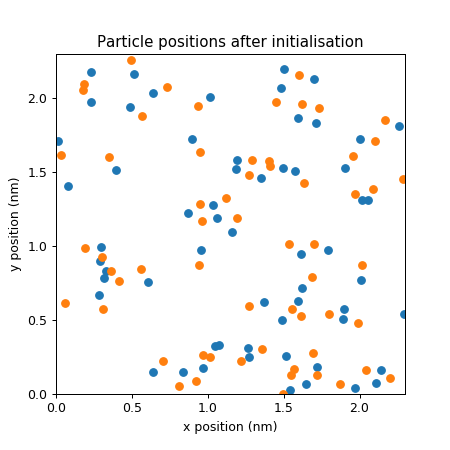

Initial potential(J) : 3.3675539127813756e-08
Final potential(J) : 3.408054959761446e-14
41


<IPython.core.display.Javascript object>


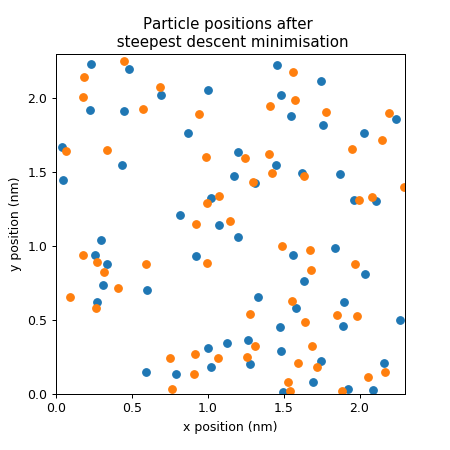

SD Done


100%|███████████████████████████████████| 10000/10000 [00:26<00:00, 375.57it/s]


In [701]:
Simulation._Simulate(Results, r0, 10000, 100, N, np.array([2.3, 2.3]), None)

Data Analysis

Simulation 1, initial temperature at 10 000K, temperature bath held at 100 K

Have a look at final positions

<IPython.core.display.Javascript object>


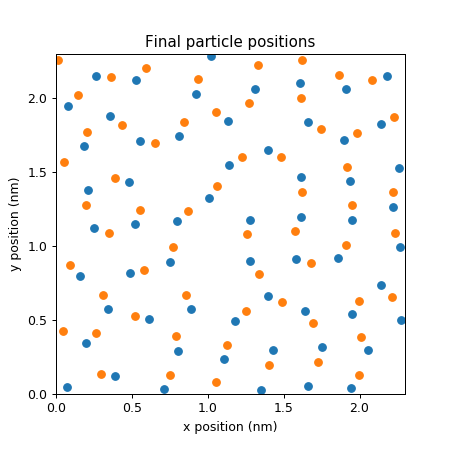

In [708]:
Simulation._Final_positions(Results)

We observe a very ordered structure, suggesting the molecules have crystalised.

Take a look at the evolution of the different potentials

<IPython.core.display.Javascript object>


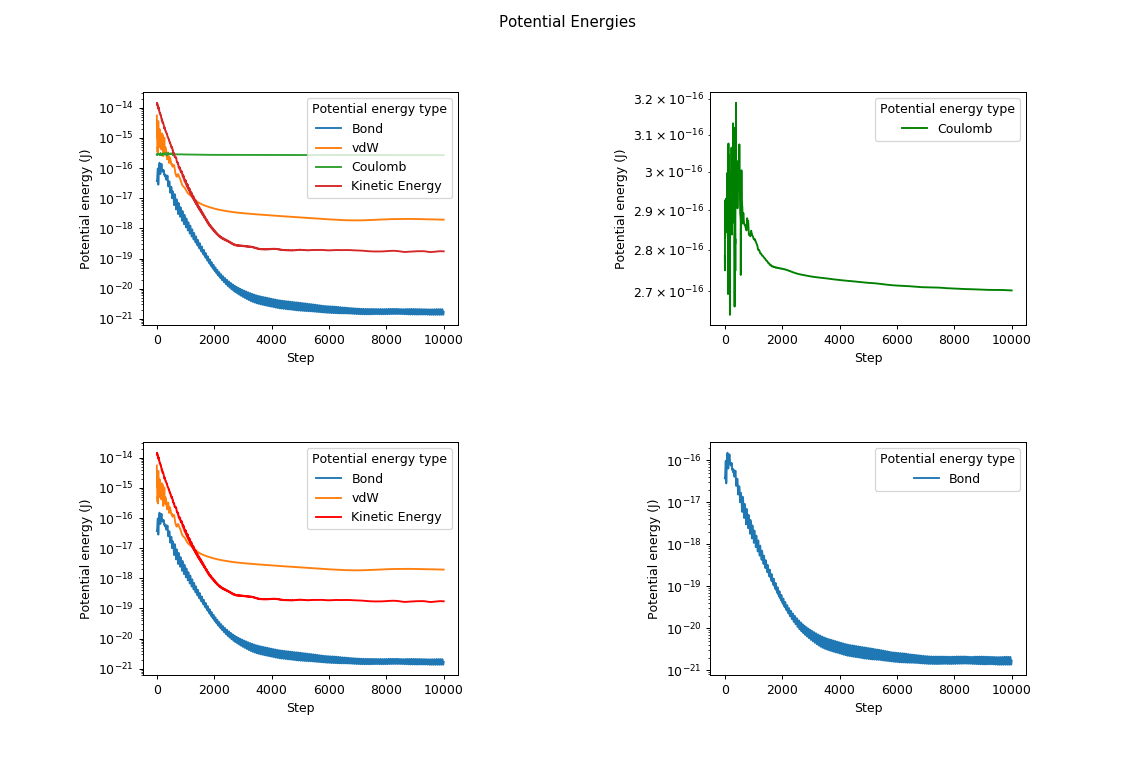

In [767]:
Simulation._Plot_Potentials(Results)

Potential energy of all kinds clearly decrease over time. The temperature bath removes excess kinetic energy, while the system enters a more energetically favourable state over time, minimising energy stored in bonds, electrostatic interactions, and van der Waals interactions.

In [768]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


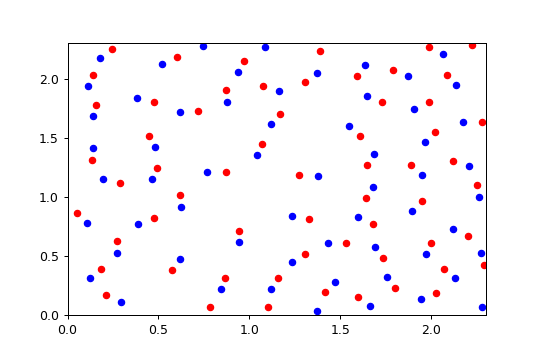

In [770]:
fig, ax = plt.subplots()

dot, = ax.plot([], [], 'bo', ms=5.0)
dot2, = ax.plot([], [], 'ro', ms=5.0)
ax.set_xlim((0, 2.3))
ax.set_ylim((0, 2.3))

def init():
    dot.set_data([], [])
    dot2.set_data([], [])
    return dot,dot2


def animate(i): 
    i = 5*i
    H_pos_i = Results.H_Positions[:, :, i]
    Cl_pos_i = Results.Cl_Positions[:, :, i]
    x = Cl_pos_i[0]
    y = Cl_pos_i[1]
    dot.set_data(x, y)
    
    x = H_pos_i[0]
    y = H_pos_i[1]
    dot2.set_data(x, y)
    
    return dot,dot2

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=10, blit=True)


plt.show()

Crytalisation can clearly be observed : particles are arranged in a regular pattern.
The radial distribution function is plotted below to support the claim

100%|███████████████████████████████████████| 325/325 [00:00<00:00, 444.91it/s]


<IPython.core.display.Javascript object>


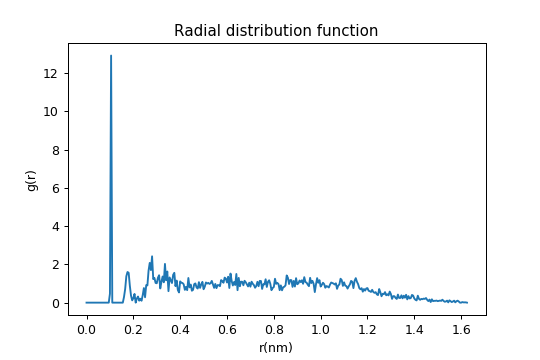

In [707]:
Simulation._Plot_RDF(Results)

The first spike is obviously due to the bonded atom. The next two spikes are also very pronounced and it takes a fairly large distannce r for fluctuations to start disappearing. This suggests long range ordering and shows our molecules have crystalised.